# Modulation Classification in 2.4 GHz ISM Band
### RML2016.10a Dataset + CNN Network

Ubeydullah Erdemir, Yunus Emre Yıldız, Mehmet Sencer Dost

The RML2016.10a datasetine bu linkten ulasabilirsiniz: 

[LINK] https://radioml.com/datasets/


In [0]:
# Google Colab Authentication
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145674 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import sys
sys.path.insert(0, 'drive/mobile_proje')

In [0]:
!pip install -q keras

In [0]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3606711221142639641, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3297246731563715224
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 457435899040910302
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11330115994
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9132999841294004951
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow
from tensorflow import keras

import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras


Using TensorFlow backend.


# Dataset setup

In [0]:
# Load the dataset ...
# Xd = pickle.load(open("RML2016.10b.dat",'rb'))
Xd = pickle.load(open("./drive/mobile_proje/RML2016.10a_dict.pkl",'rb'),  encoding='latin1')

# Pick SNR and Modulations or take them all
# snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
snrs = [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18] #
mods = [ 'BPSK','QPSK','QAM16','QAM64','GFSK'] # GFSK:Bluetooth, QAM16-64:Wi-Fi

Z = []
lbl = []
samp = 1000
for mod in mods:
    for snr in snrs:
        Z.append(Xd[(mod,snr)][0:samp])
        for i in range(samp):  lbl.append((mod,snr))
Z = np.vstack(Z)
# To complex values...
V = Z[:,0,:]+1j*Z[:,1,:]
X = []
# Amplitude and Phase conversion (It is NOT used. Gives poor result)
for i in range(V.shape[0]):
        X.append([Z[i][0], Z[i][1]]) # abs(V[i]), np.angle(V[i]) 
X = np.asarray(X)


(100000, 2, 128)
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
['BPSK', 'QPSK', 'QAM16', 'QAM64', 'GFSK']


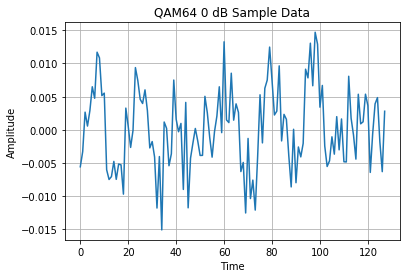

In [0]:
print(np.shape(X))
print(snrs)
print(mods)
plt.plot(Xd['QAM64',-10][2,0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("QAM64 0 dB Sample Data")
plt.grid(b=True, axis='both')


In [0]:
# Partition the data
np.random.seed(2019)
n_examples = X.shape[0]
n_train = int(n_examples * 0.8)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))


In [0]:
print(n_examples)
print(np.shape(Y_test))

100000
(20000, 5)


In [0]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods


(80000, 2, 128) [2, 128]


# Build the NN Model

In [0]:
# Building the NN
dr = 0.3 # dropout rate (%)
model = tf.keras.models.Sequential()

model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(Convolution2D(padding="same", filters=512, kernel_size=(2,4), kernel_initializer="glorot_uniform", name="conv1", activation="relu", data_format="channels_first"))
model.add(MaxPooling2D(pool_size=(1,16), padding="same",data_format="channels_first"))
model.add(Dropout(dr))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dense(140, activation='relu', kernel_initializer='he_normal', name="dense2"))
model.add(Dense(30, activation='relu', kernel_initializer='he_normal', name="dense3"))

model.add(Dense(len(classes), kernel_initializer='he_normal', name="dense7" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
opt = tf.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 512, 2, 128)       4608      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 2, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 2, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense1 (Dense)               (None, 256)               2097408   
_________________________________________

# Train the Model

In [0]:
# Train the model
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 256 # training batch size

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    validation_data=(X_test, Y_test),
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 80000 samples, validate on 20000 samples
Epoch 1/100
80000/80000 [==============================] - 17s 214us/sample - loss: 1.4640 - acc: 0.3135 - val_loss: 1.3320 - val_acc: 0.3690
Epoch 2/100
80000/80000 [==============================] - 11s 138us/sample - loss: 1.3302 - acc: 0.3902 - val_loss: 1.2610 - val_acc: 0.4178
Epoch 3/100
80000/80000 [==============================] - 11s 138us/sample - loss: 1.2492 - acc: 0.4217 - val_loss: 1.2040 - val_acc: 0.4342
Epoch 4/100
80000/80000 [==============================] - 11s 139us/sample - loss: 1.2025 - acc: 0.4450 - val_loss: 1.1724 - val_acc: 0.4548
Epoch 5/100
80000/80000 [==============================] - 11s 137us/sample - loss: 1.1566 - acc: 0.4645 - val_loss: 1.2158 - val_acc: 0.4437
Epoch 6/100
80000/80000 [==============================] - 11s 138us/sample - loss: 1.1313 - acc: 0.4745 - val_loss: 1.0990 - val_acc: 0.4909
Epoc

# Evaluate and Plot Model Performance

In [0]:
# Show simple version of performance
score,accuracy = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print(score)
print(accuracy)

0.8372243418693542
0.5943


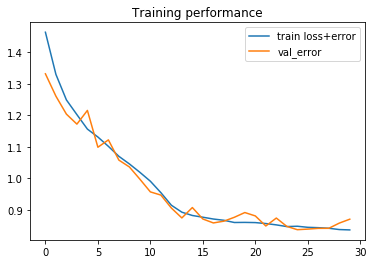

In [0]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(len(cm)):
        for j in range(len(cm)):
            plt.text(i,j,np.around(cm[i,j],decimals=2),ha="center", va="center", color="black")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

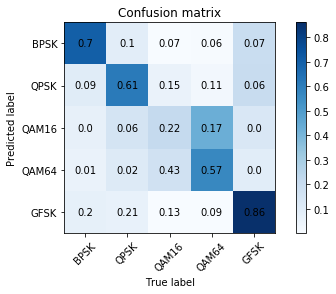

In [0]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.17688442211055277 SNR:  -20
Overall Accuracy:  0.20462962962962963 SNR:  -18
Overall Accuracy:  0.22291666666666668 SNR:  -16
Overall Accuracy:  0.22487046632124352 SNR:  -14
Overall Accuracy:  0.28362573099415206 SNR:  -12
Overall Accuracy:  0.3329979879275654 SNR:  -10
Overall Accuracy:  0.43371017471736895 SNR:  -8
Overall Accuracy:  0.6276803118908382 SNR:  -6
Overall Accuracy:  0.7217741935483871 SNR:  -4
Overall Accuracy:  0.7554709800190295 SNR:  -2
Overall Accuracy:  0.7758964143426295 SNR:  0
Overall Accuracy:  0.7850655903128153 SNR:  2
Overall Accuracy:  0.7902097902097902 SNR:  4
Overall Accuracy:  0.8118006103763988 SNR:  6
Overall Accuracy:  0.7831683168316832 SNR:  8
Overall Accuracy:  0.8073022312373225 SNR:  10
Overall Accuracy:  0.8036437246963563 SNR:  12
Overall Accuracy:  0.8 SNR:  14
Overall Accuracy:  0.7843530591775326 SNR:  16
Overall Accuracy:  0.768056968463886 SNR:  18


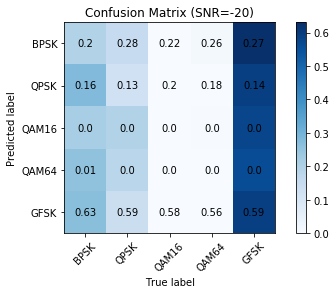

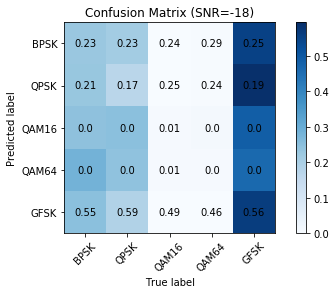

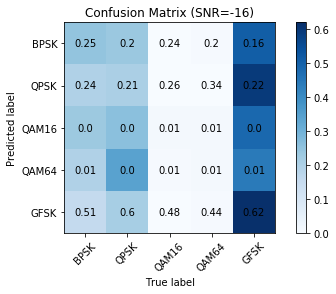

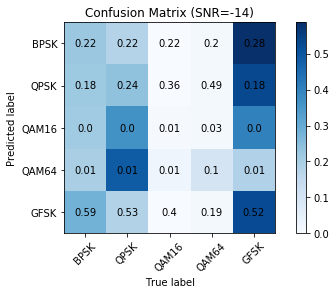

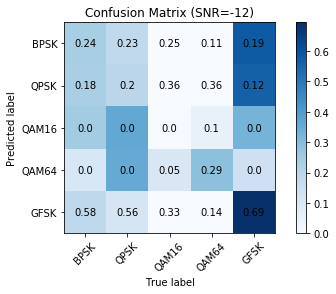

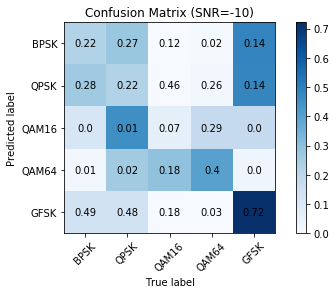

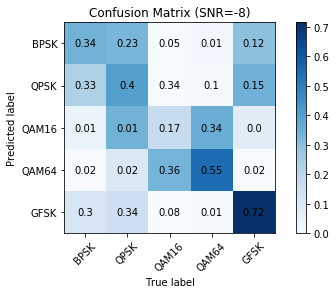

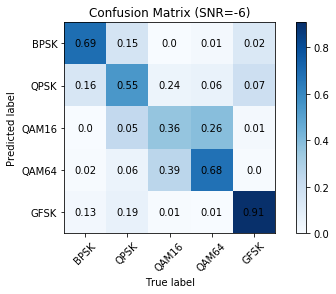

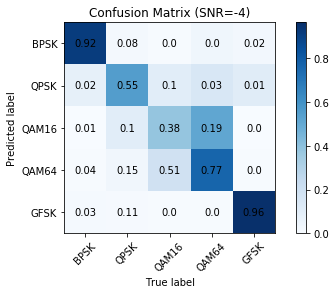

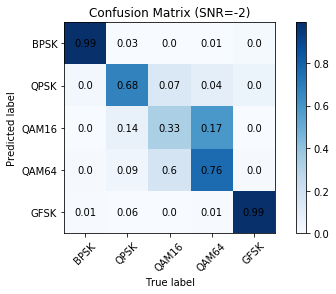

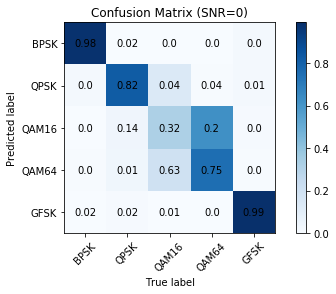

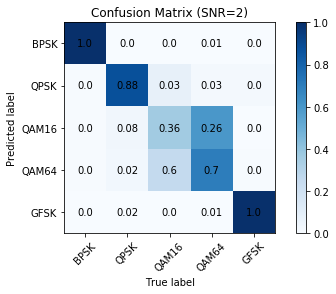

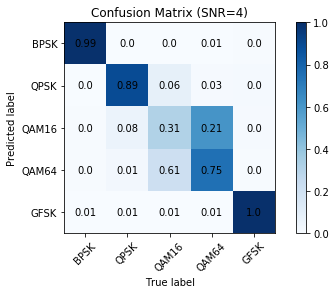

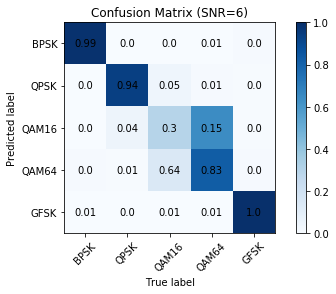

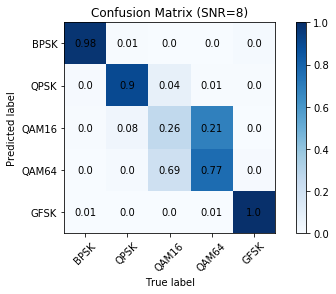

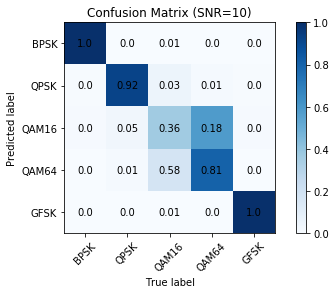

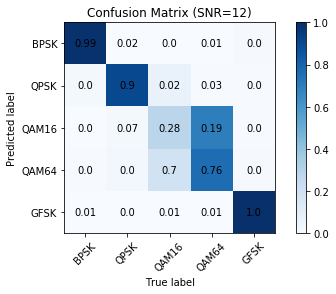

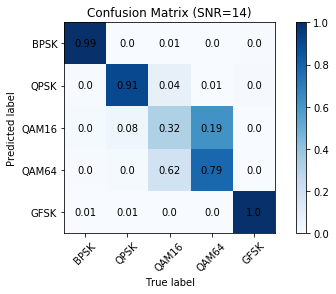

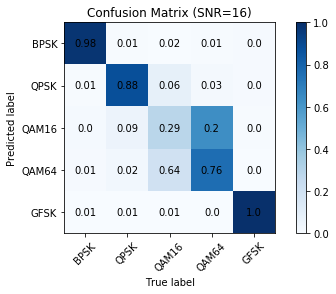

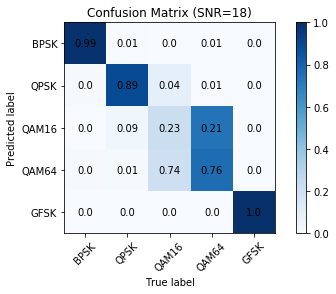

In [0]:
# Plot confusion matrix by SNR
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    # print(test_SNRs)
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    # print(test_Y_i_hat)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("Overall Accuracy: ", cor / (cor+ncor),"SNR: ",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    

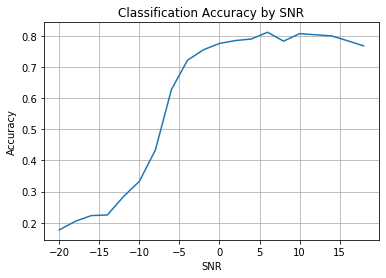

In [0]:
# Plot accuracy curve
a = list(map(lambda x: acc[x], snrs))
plt.plot(snrs,a)
plt.xlabel("SNR")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy by SNR")
plt.grid(b=True, axis='both')